In [630]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# Used to color bar charts for each team
color_df = pd.read_csv("Data/team_colors.csv")

In [631]:
df_original = pd.read_csv("Data/clean/master_data.csv")
df_merged = df_original.merge(color_df, on="Team", how="left")
df_merged["log salary"] = np.log(df_merged["Salary"])
df_original["log salary"] = np.log(df_original["Salary"])
df_merged

,Player,Player-additional,Team,MP,OBPM,DBPM,VORP,Pos,Year,Salary,hex,log salary
0,Precious Achiuwa,achiupr01,MIA,737,-3.6,-0.5,-0.4,PF,2021,2582160.0,#98002E,14.764137
1,Precious Achiuwa,achiupr01,TOR,1725,-2.0,-0.6,-0.2,C,2022,2711280.0,#CE1141,14.812931
2,Precious Achiuwa,achiupr01,TOR,1140,-1.4,-0.8,-0.1,C,2023,2840160.0,#CE1141,14.859371
3,Precious Achiuwa,achiupr01,NYK,1187,-1.9,0.5,0.2,PF,2024,4379527.0,#F58426,15.292451
4,Precious Achiuwa,achiupr01,NYK,1170,-2.1,0.2,0.0,C,2025,6000000.0,#F58426,15.607270
...,...,...,...,...,...,...,...,...,...,...,...,...
2315,Ivica Zubac,zubaciv01,LAC,1609,0.6,0.4,1.2,C,2021,7000000.0,#C8102E,15.761421
2316,Ivica Zubac,zubaciv01,LAC,1852,-0.1,0.8,1.3,C,2022,7518518.0,#C8102E,15.832880
2317,Ivica Zubac,zubaciv01,LAC,2170,-1.1,0.2,0.6,C,2023,10123457.0,#C8102E,16.130366
2318,Ivica Zubac,zubaciv01,LAC,1794,0.8,0.0,1.3,C,2024,10933333.0,#C8102E,16.207327


Text(0.5, 0, 'Salary ($)')

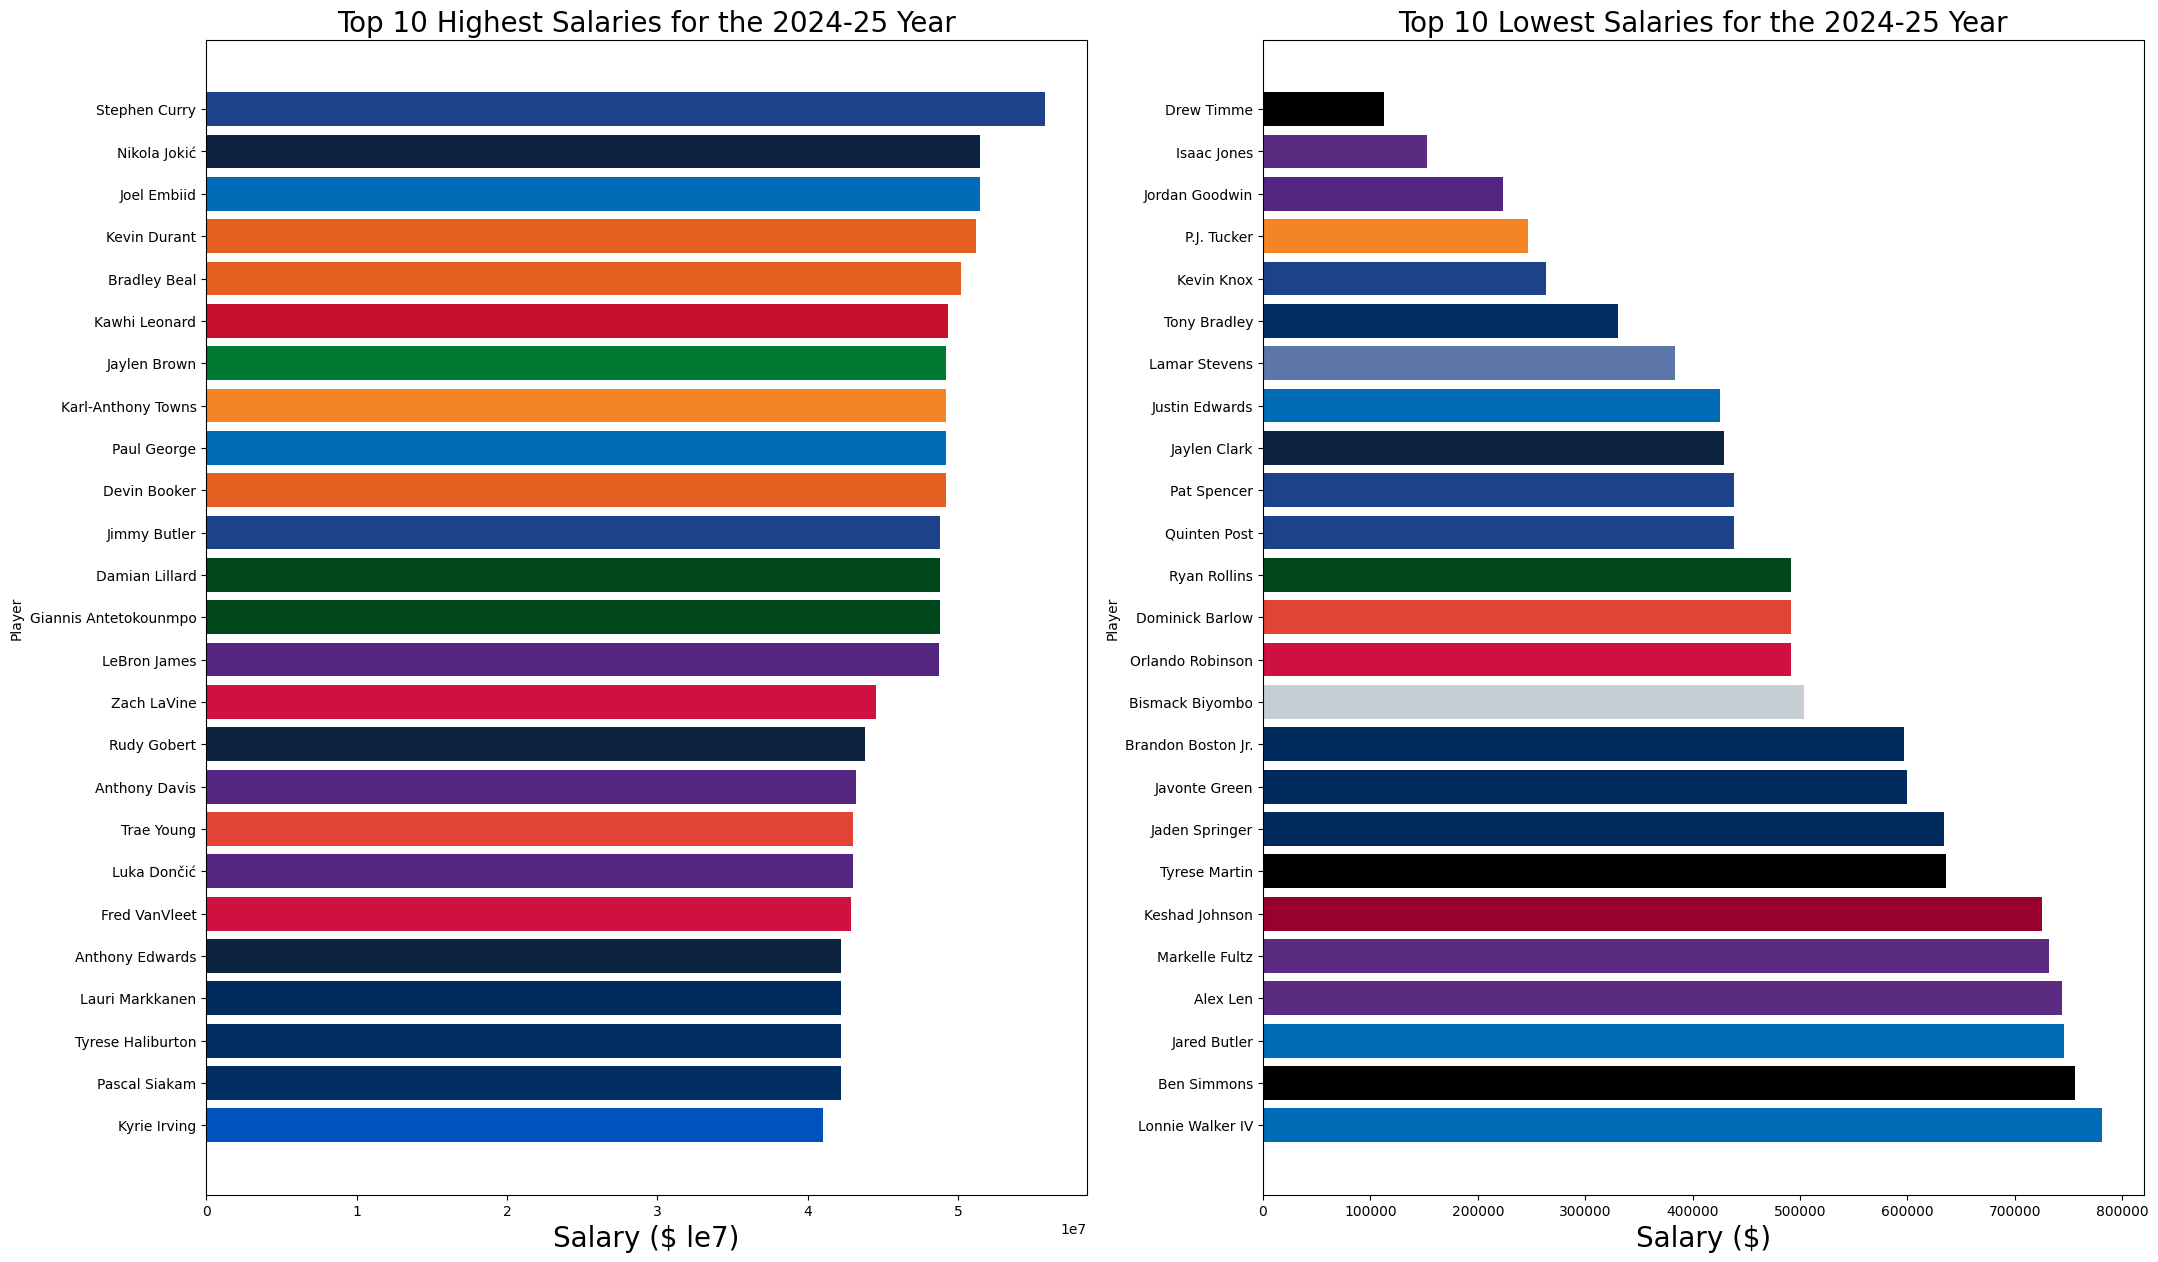

In [632]:
# EDA For 2025

df_2025 = df_merged[df_merged["Year"] == 2025]

highest_paid_10 = df_2025.sort_values("Salary", ascending=False).head(25).sort_values("Salary", ascending=True)
lowest_paid_10 = df_2025.sort_values("Salary", ascending=True).head(25).sort_values("Salary", ascending=False)

fig, ax = plt.subplots(1, 2, figsize=(25, 15), sharey=False)


ax[0].barh(highest_paid_10["Player"], highest_paid_10["Salary"], color=highest_paid_10["hex"])


ax[0].set_title("Top 10 Highest Salaries for the 2024-25 Year", size=20, y=1)
ax[0].set_ylabel("Player")
ax[0].set
ax[0].set_xlabel("Salary ($ le7)", size=20)


ax[1].barh(y=lowest_paid_10["Player"], width = lowest_paid_10["Salary"], color=lowest_paid_10["hex"])
ax[1].set_title("Top 10 Lowest Salaries for the 2024-25 Year", size=20, y = 1)
ax[1].set_ylabel("Player")
ax[1].set
ax[1].set_xlabel("Salary ($)", size=20)

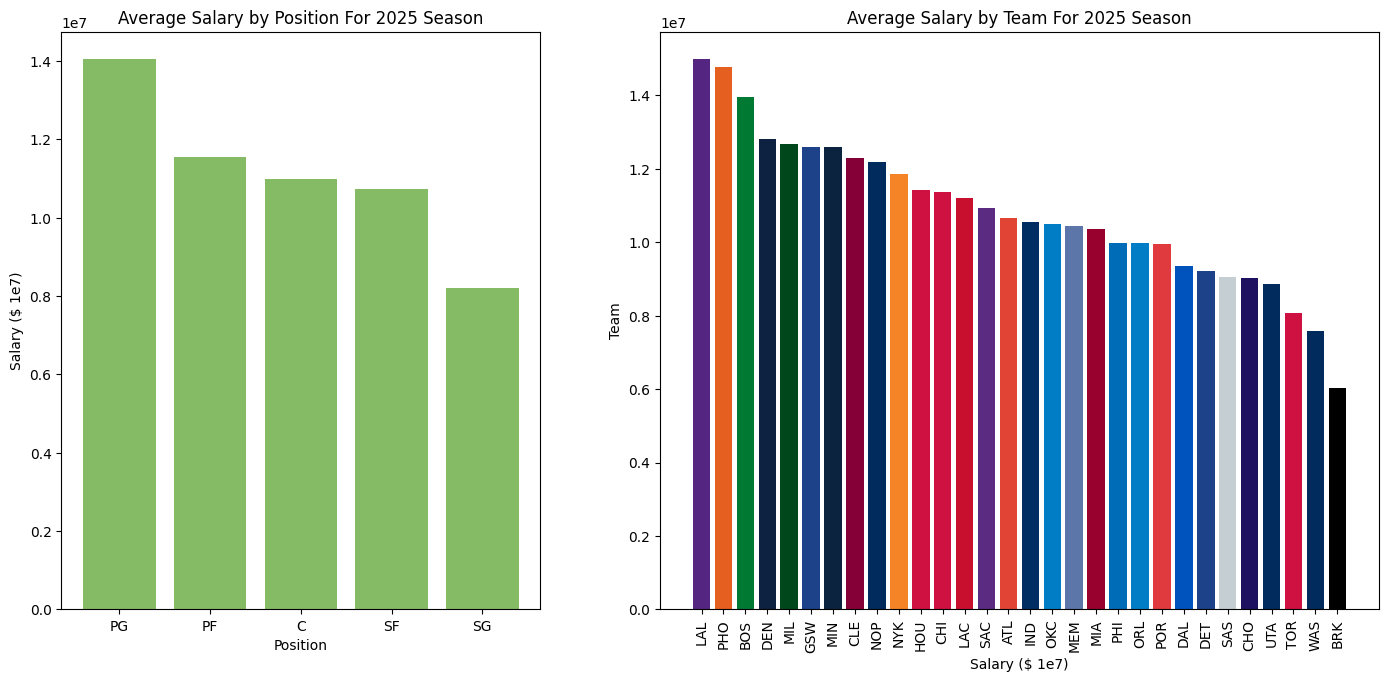

In [693]:
pos_2025 = df_2025.groupby("Pos", as_index=False).mean(numeric_only=True).sort_values("Salary", ascending=False)
team_2025 = df_2025.groupby("Team", as_index=False).mean(numeric_only=True).sort_values("Salary", ascending=False)
colors = team_2025.merge(color_df, on="Team", how="left")
fig, ax = plt.subplots(1, 2, figsize=(17, 7.5), sharey=False, gridspec_kw={"width_ratios": [2, 3]})


ax[0].bar(x=pos_2025["Pos"], height=pos_2025["Salary"], color="#85BB65")
ax[0].set_xlabel("Position")
ax[0].set_ylabel("Salary ($ 1e7)")
ax[0].set_title("Average Salary by Position For 2025 Season")

ax[1].bar(x=team_2025["Team"], height=team_2025["Salary"], color=colors["hex"])
ax[1].set_ylabel("Team")
ax[1].set_xlabel("Salary ($ 1e7)")
ax[1].set_title("Average Salary by Team For 2025 Season")
ax[1].tick_params(axis='x', labelrotation=90)

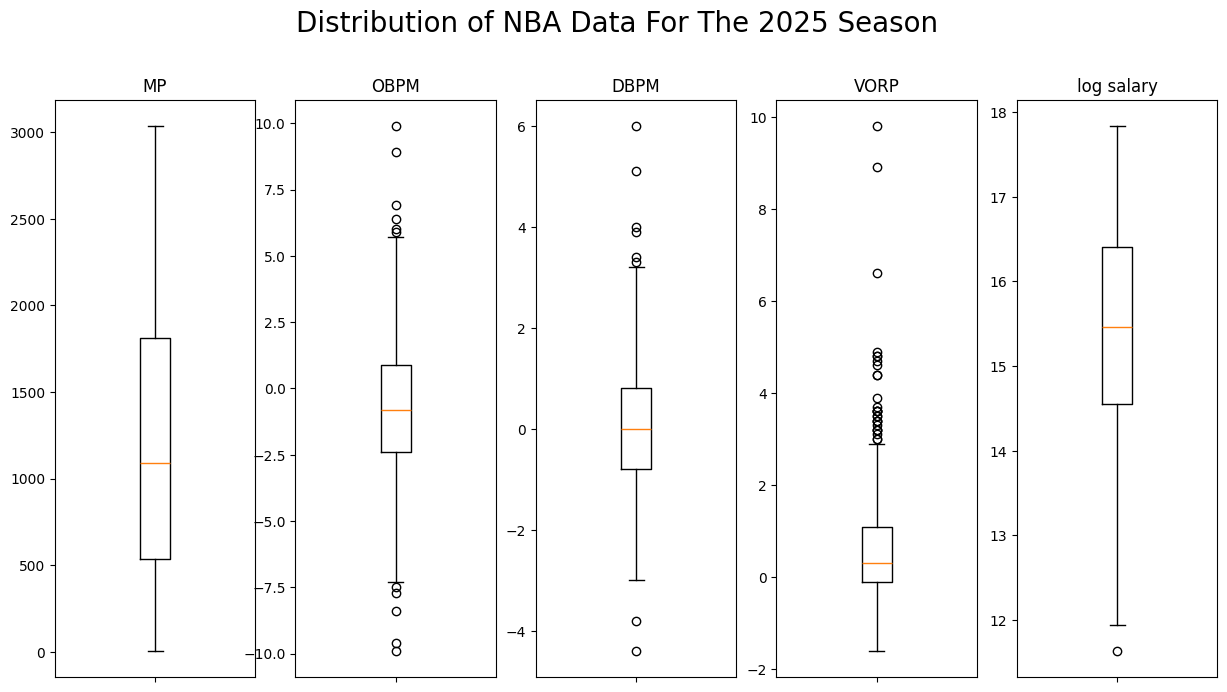

In [634]:
fig, ax = plt.subplots(1, 5, figsize=(15, 7.5), sharey=False)

cols = ["MP", "OBPM", "DBPM", "VORP", "log salary"]

for j, col in enumerate(cols):
    ax[j].boxplot(df_2025[col].dropna())
    ax[j].set_title(col)
    ax[j].tick_params(axis="x", labelbottom=False)

fig.suptitle("Distribution of NBA Data For The 2025 Season", fontsize=20, y=1)
plt.show()


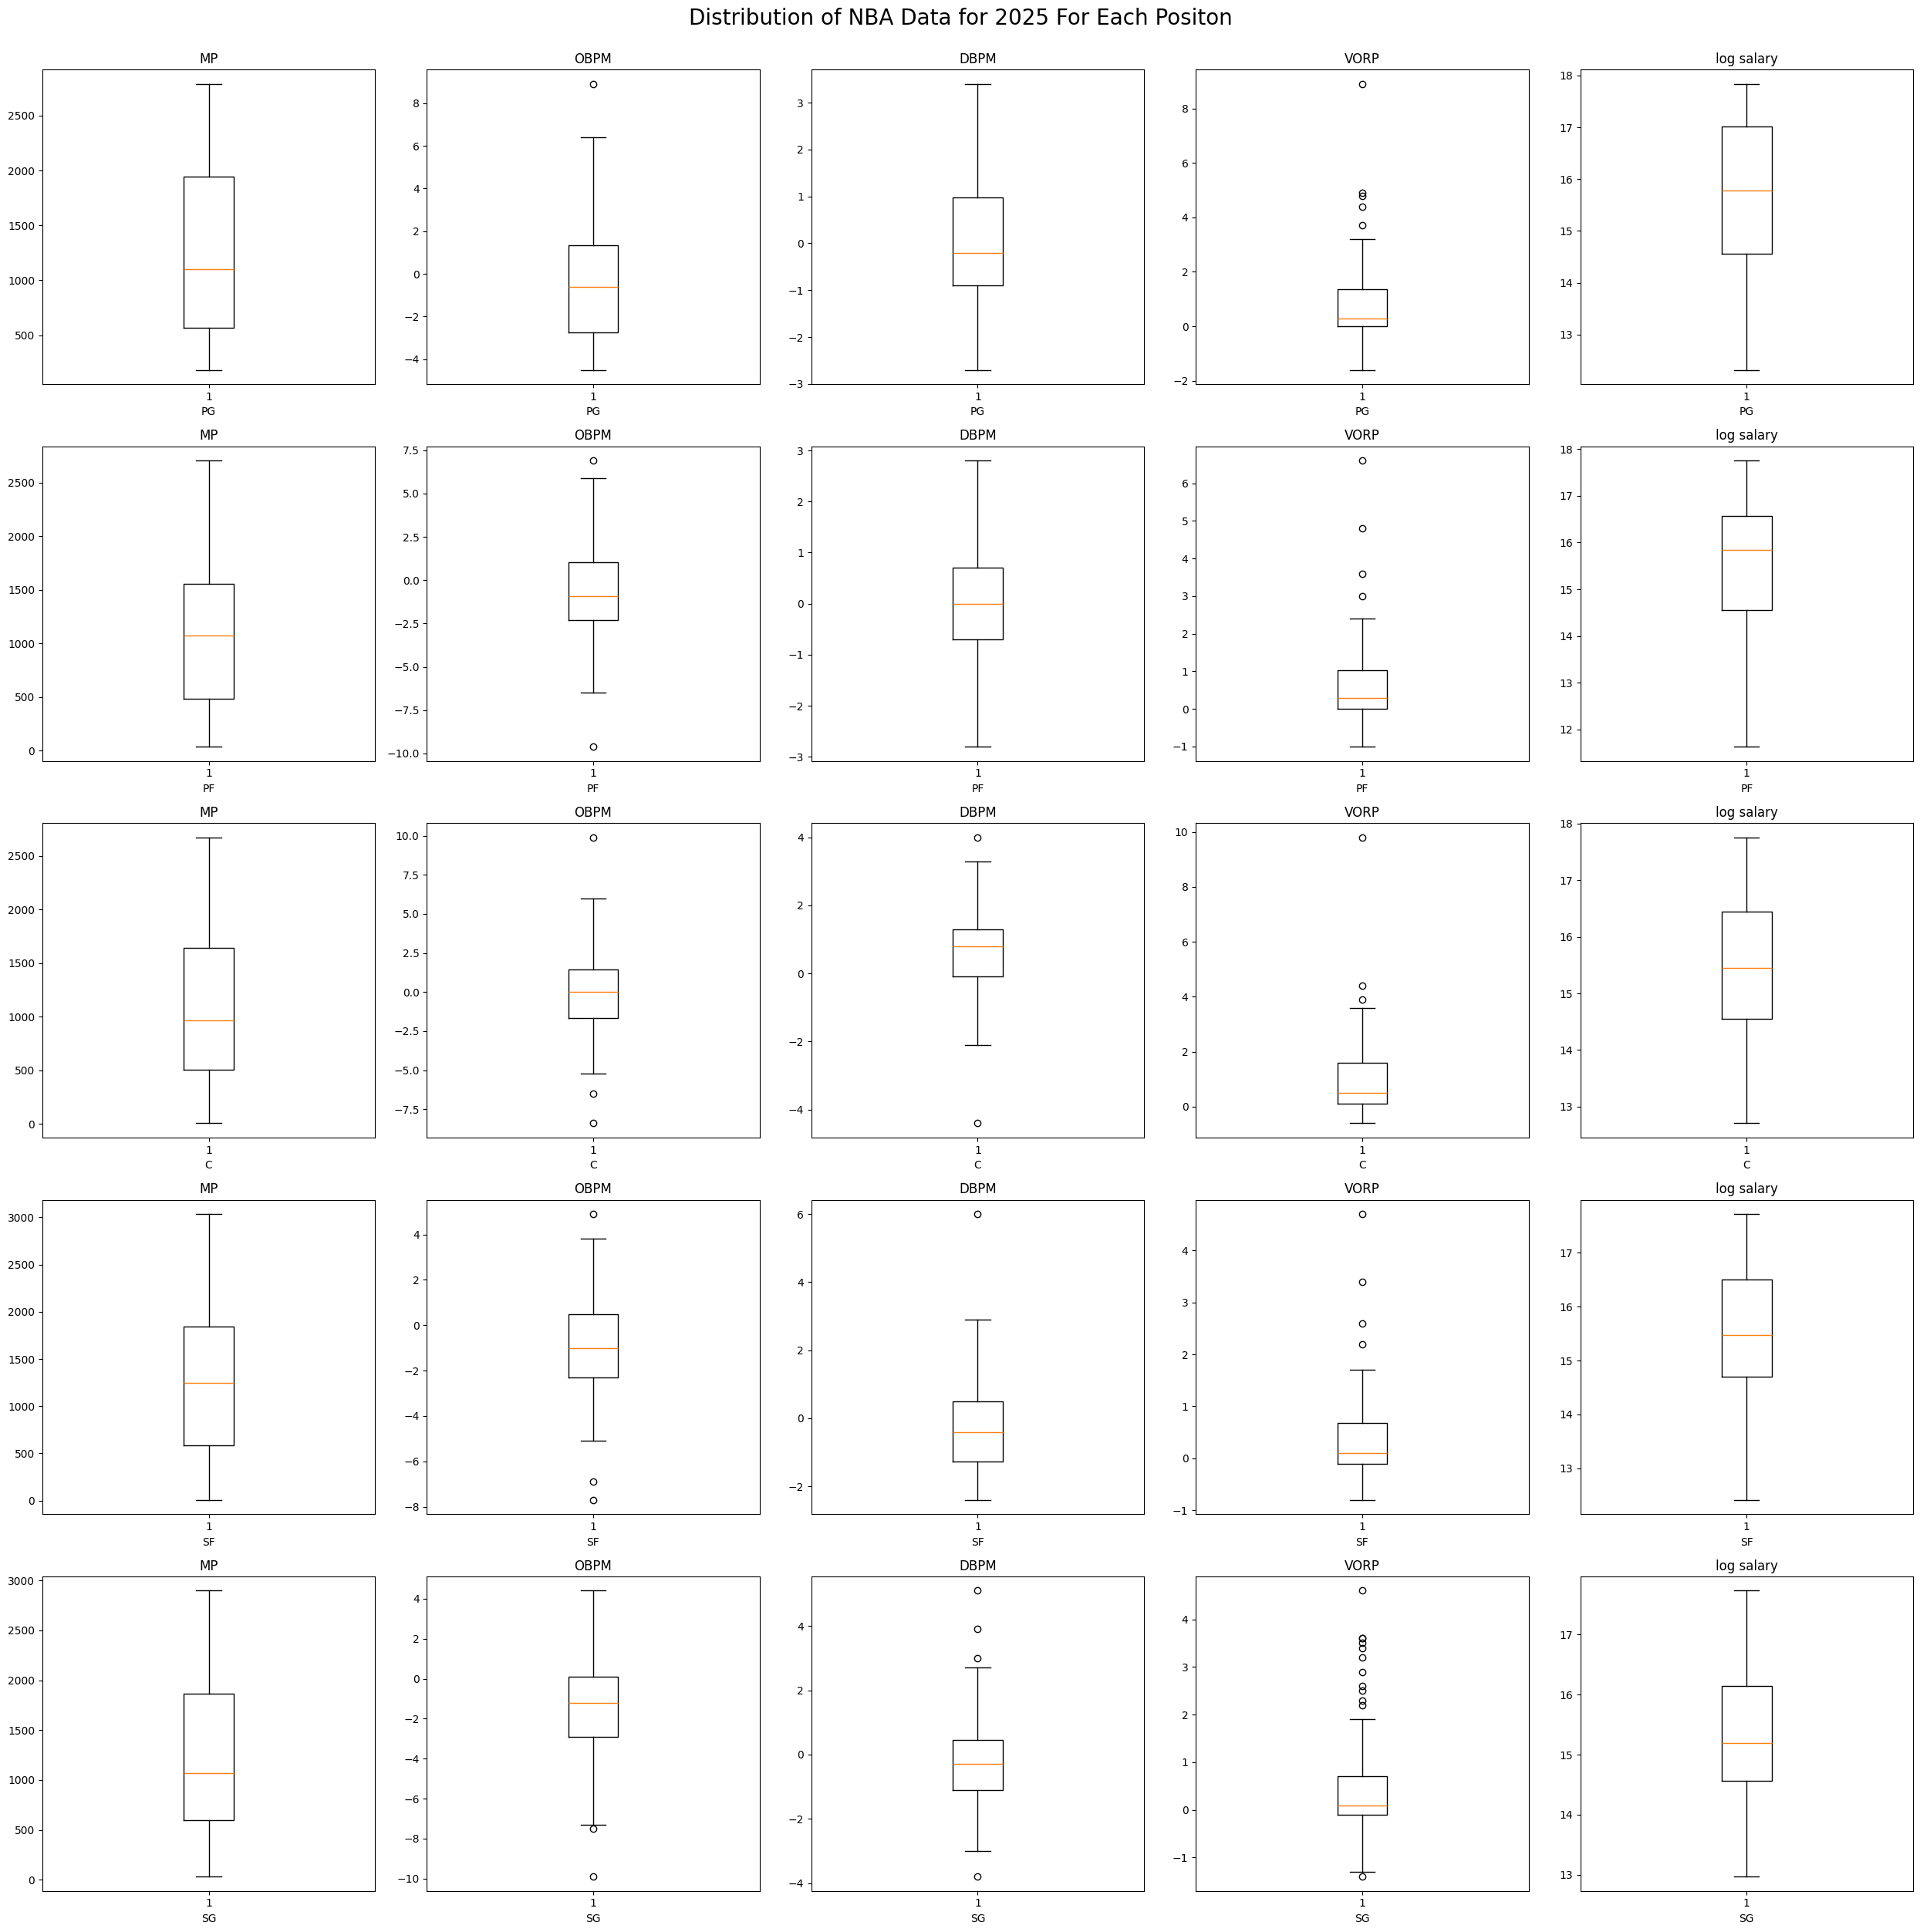

In [635]:
fig, ax = plt.subplots(5, 5, figsize=(25, 25), sharey=False)

cols = ["MP", "OBPM", "DBPM", "VORP", "log salary"]
pos = ["PG", "PF", "C", "SF", "SG"]  

for i, p in enumerate(pos):                 # rows
    dfp = df_2025[df_2025["Pos"] == p]      
    for j, col in enumerate(cols):          # cols
        ax[i, j].boxplot(dfp[col].dropna(), vert=True)
        ax[i, j].set_title(col)
        ax[i, j].set_xlabel(p)

fig.suptitle("Distribution of NBA Data for 2025 For Each Positon", fontsize=20, y=1 )
plt.tight_layout()
plt.show()

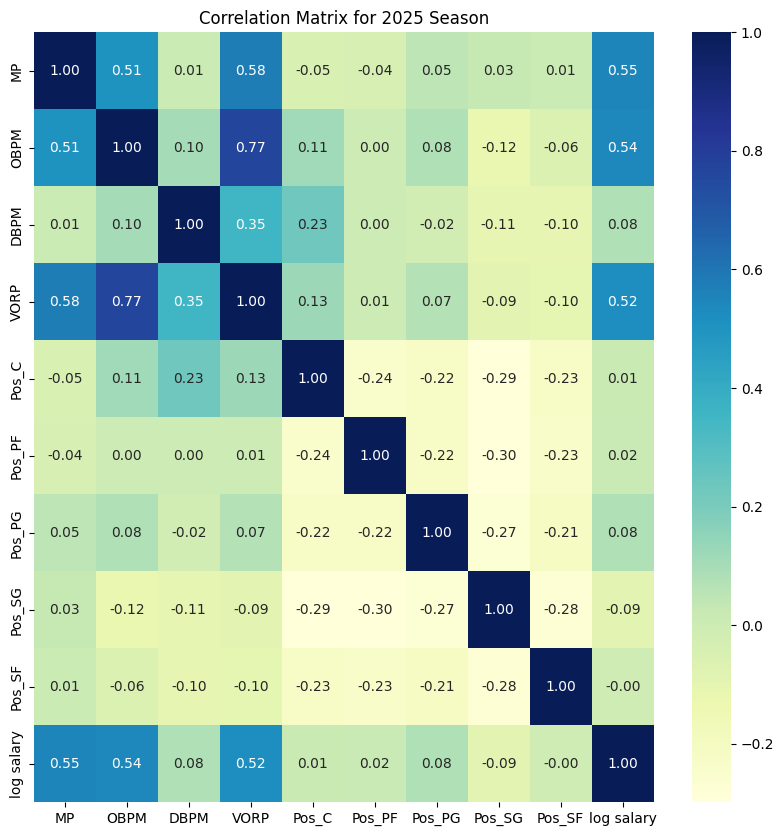

In [636]:
pos_encoded = pd.get_dummies(df_2025['Pos'], prefix='Pos', dtype=int)
df = pd.concat([df_2025, pos_encoded], axis=1)


df_corr = df[["MP", "OBPM", "DBPM", "VORP", "Pos_C", "Pos_PF", "Pos_PG", "Pos_SG", "Pos_SF", "log salary"]].corr()
plt.figure(figsize=(10, 10))
sns.heatmap(df_corr, cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Correlation Matrix for 2025 Season") 
plt.show() 

In [637]:
df_corr["log salary"].sort_values(ascending=False)

log salary    1.000000
MP            0.552239
OBPM          0.542379
VORP          0.518577
DBPM          0.077350
Pos_PG        0.076834
Pos_PF        0.019713
Pos_C         0.013404
Pos_SF       -0.002306
Pos_SG       -0.092651
Name: log salary, dtype: float64

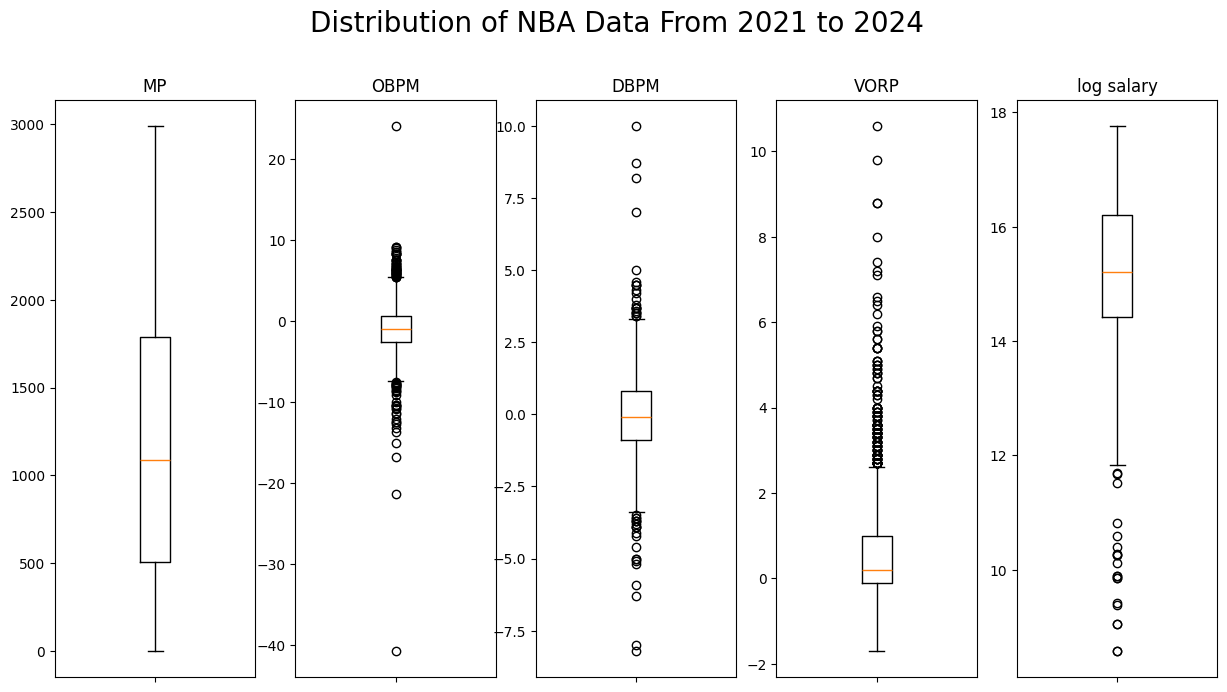

In [638]:
fig, ax = plt.subplots(1, 5, figsize=(15, 7.5), sharey=False)

cols = ["MP", "OBPM", "DBPM", "VORP", "log salary"]

training_df = df_original[df_original["Year"].isin([2020,2021,2022,2023,2024])]

for j, col in enumerate(cols):
    ax[j].boxplot(training_df[col].dropna())
    ax[j].set_title(col)
    ax[j].tick_params(axis="x", labelbottom=False)

fig.suptitle("Distribution of NBA Data From 2021 to 2024", fontsize=20, y=1)
plt.show()


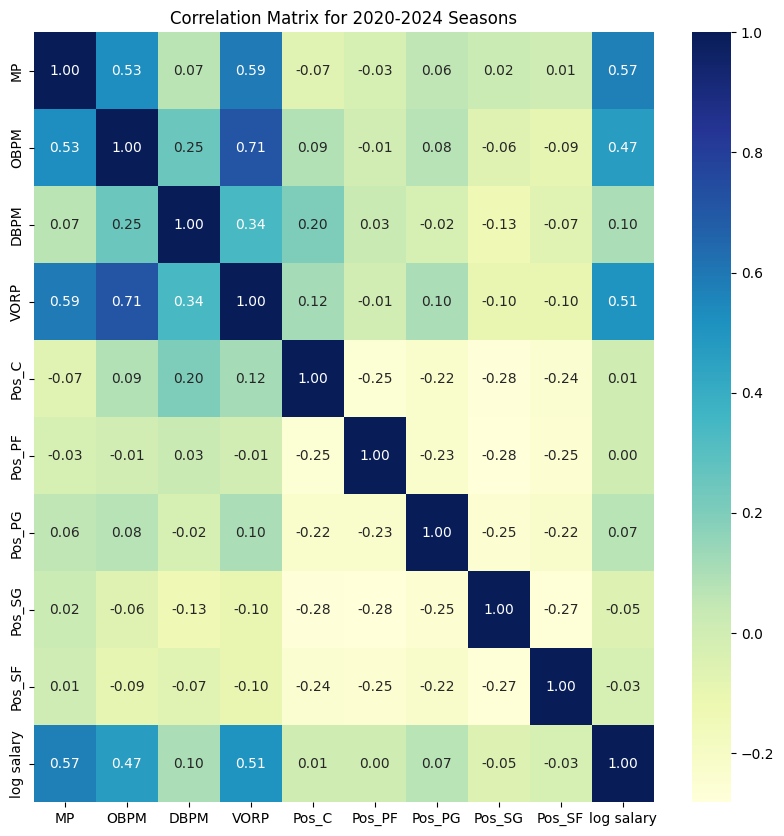

In [639]:
pos_encoded = pd.get_dummies(df_original['Pos'], prefix='Pos', dtype=int)
df = pd.concat([df_original, pos_encoded], axis=1)

df_corr = df[["MP", "OBPM", "DBPM", "VORP", "Pos_C", "Pos_PF", "Pos_PG", "Pos_SG", "Pos_SF", "log salary"]].corr()

plt.figure(figsize=(10, 10))
sns.heatmap(df_corr, cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Correlation Matrix for 2020-2024 Seasons") 
plt.show() 

In [640]:
df_corr["log salary"].sort_values(ascending=False)

log salary    1.000000
MP            0.573303
VORP          0.507431
OBPM          0.471603
DBPM          0.101795
Pos_PG        0.068656
Pos_C         0.007949
Pos_PF        0.004706
Pos_SF       -0.025842
Pos_SG       -0.048783
Name: log salary, dtype: float64

In [641]:
features = ["VORP", "OBPM", "MP", "Pos_PG", "DBPM", "Pos_PF", "Pos_C", "Pos_SF", "Pos_SG"]

df_train = df[df["Year"] != 2025]
df_test = df[df["Year"] == 2025]

X_train = df_train[features] 
y_train = df_train["log salary"]

X_test = df_test[features] 
y_test = df_test["log salary"]
 


In [642]:
# 2. Initialize the model
# Use 'objective="multi:softprob"' for multi-class, or simply let XGBoost handle it automatically
model = xgb.XGBRegressor(objective='reg:squarederror',
                         n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.3f}')
print(f'R²: {r2:.3f}')

RMSE: 1.083
R²: 0.192


In [643]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform, loguniform

param_dist = {
    "learning_rate": loguniform(0.01, 0.3),
    "n_estimators": randint(300, 3001),
    "max_depth": randint(2, 11),
    "min_child_weight": randint(1, 21),
    "subsample": uniform(0.6, 0.4),          
    "colsample_bytree": uniform(0.5, 0.5),   
    "reg_alpha": uniform(0.0, 10.0),
    "reg_lambda": uniform(0.5, 49.5),       
    "gamma": uniform(0.0, 10.0),
}

search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=75,
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)
         
search.fit(X_train, y_train)
best_params = search.best_params_ 

print("Best params:", best_params)
print("Best CV score:", search.best_score_)

Fitting 3 folds for each of 75 candidates, totalling 225 fits
Best params: {'colsample_bytree': np.float64(0.9192403818819925), 'gamma': np.float64(4.260914750469411), 'learning_rate': np.float64(0.021319271345140136), 'max_depth': 10, 'min_child_weight': 18, 'n_estimators': 2981, 'reg_alpha': np.float64(1.4660482169202549), 'reg_lambda': np.float64(25.909645350273447), 'subsample': np.float64(0.6932912289698111)}
Best CV score: 0.4022748528522988


In [644]:
new_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
    **best_params
)

new_model.fit(X_train, y_train)
y_pred = new_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.3f}')
print(f'R²: {r2:.3f}')

RMSE: 0.946
R²: 0.383


In [645]:
df_test = df.loc[df["Year"] == 2025].copy()
df_test.loc[:, "Predicted Log Salary"] = new_model.predict(df_test[features])
df_test["Residual"] = df_test["log salary"] - df_test["Predicted Log Salary"]
df_test.sort_values("Residual", ascending=True).head(10)

,Player,Player-additional,Team,MP,OBPM,DBPM,VORP,Pos,Year,Salary,log salary,Pos_C,Pos_PF,Pos_PG,Pos_SF,Pos_SG,Predicted Log Salary,Residual
1102,Isaac Jones,jonesis01,SAC,304,-0.9,-0.8,0.0,PF,2025,152957.0,11.937912,0,1,0,0,0,14.617988,-2.680076
736,Jordan Goodwin,goodwjo01,LAL,543,-1.7,0.8,0.2,PG,2025,223718.0,12.318142,0,0,1,0,0,14.817760,-2.499619
2057,Drew Timme,timmedr01,BRK,254,-3.9,-2.8,-0.3,PF,2025,113055.0,11.635630,0,1,0,0,0,14.132456,-2.496826
1717,Quinten Post,postqu01,GSW,686,0.1,0.0,0.4,PF,2025,438920.0,12.992072,0,1,0,0,0,15.275439,-2.283367
606,Justin Edwards,edwarju01,PHI,1155,-2.1,-1.6,-0.5,SF,2025,425619.0,12.961300,0,0,0,1,0,15.029985,-2.068686
1043,Ty Jerome,jeromty01,CLE,1392,3.5,0.8,2.2,SG,2025,2560975.0,14.755899,0,0,0,0,1,16.718599,-1.962701
1342,Tyrese Martin,martity01,BRK,1315,-1.4,-1.2,-0.2,SG,2025,635853.0,13.362723,0,0,0,0,1,15.320308,-1.957585
1822,Ryan Rollins,rolliry01,MIL,820,-1.4,0.9,0.3,PG,2025,491887.0,13.106004,0,0,1,0,0,14.956583,-1.850579
1115,Tyus Jones,jonesty01,PHO,2174,1.4,-1.3,1.1,PG,2025,2087519.0,14.551487,0,0,1,0,0,16.289175,-1.737688
410,Jaylen Clark,clarkja02,MIN,522,-2.9,2.7,0.2,SG,2025,429323.0,12.969965,0,0,0,0,1,14.656085,-1.686120


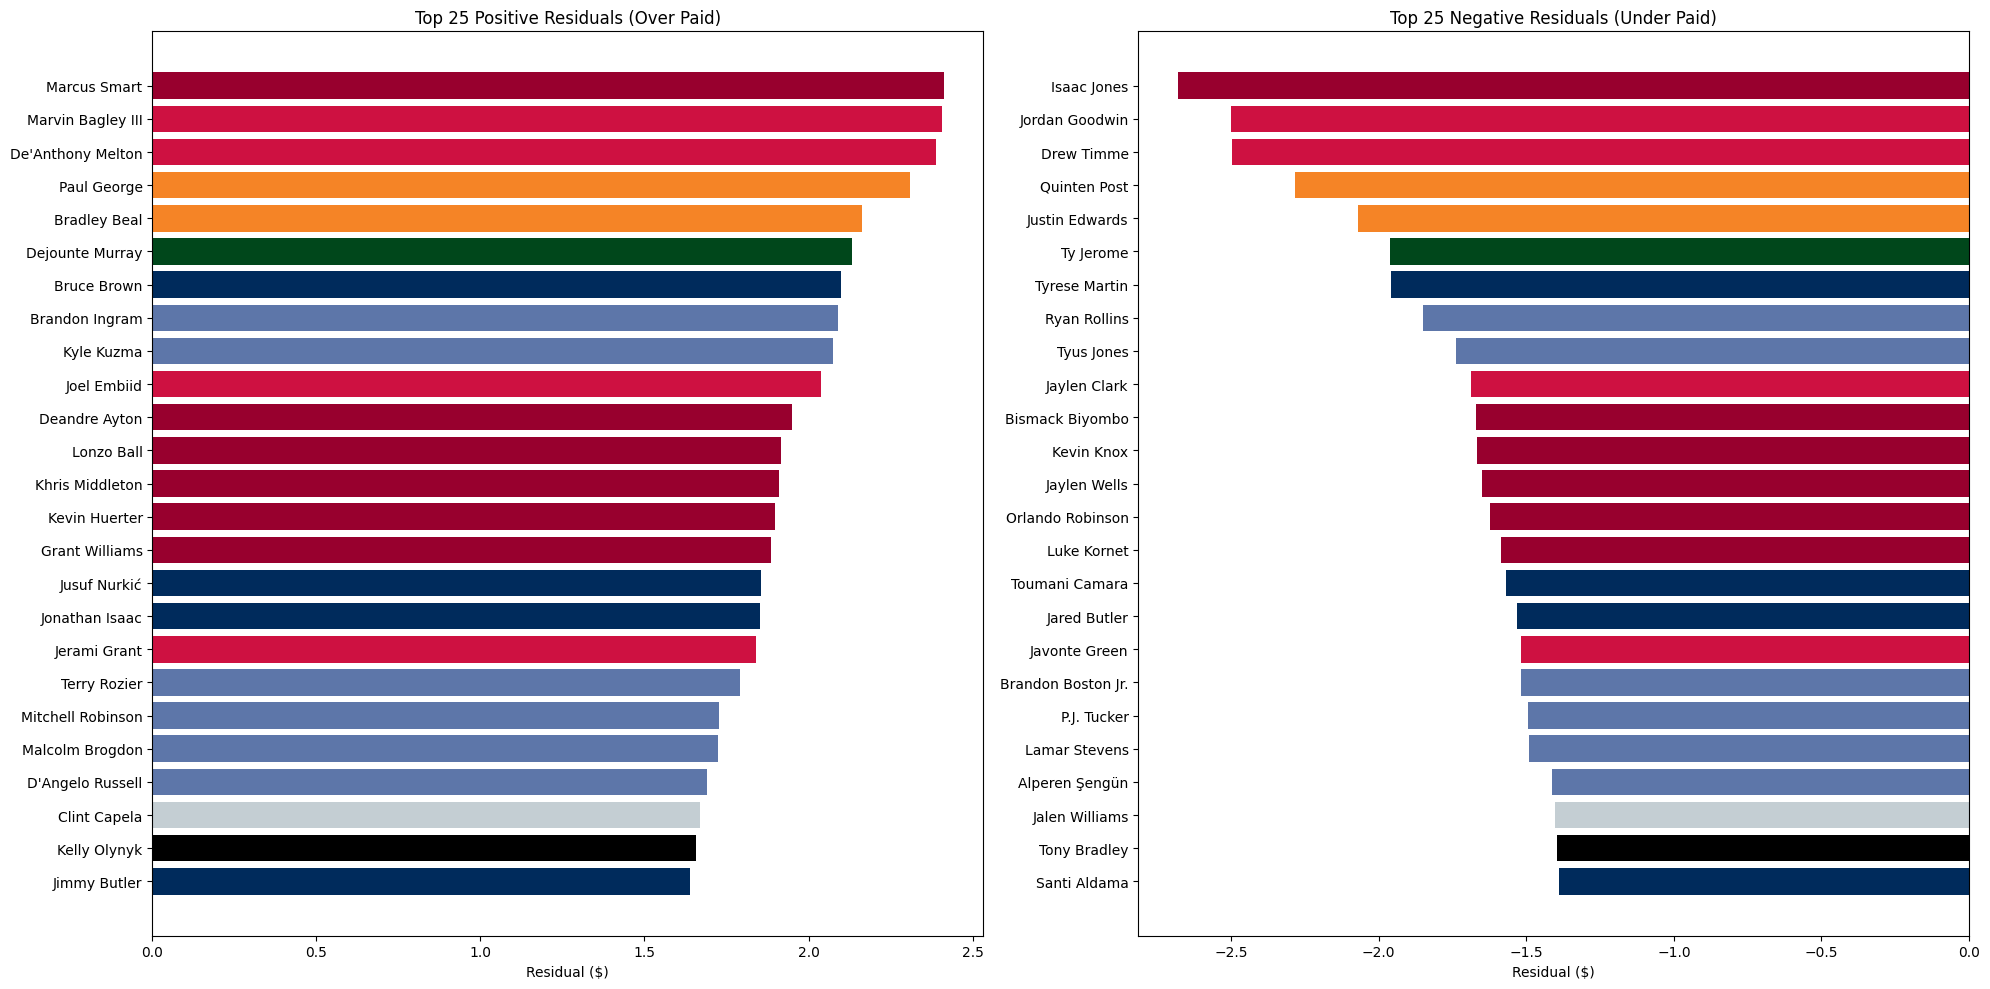

In [646]:


top_25 = df_test.sort_values("Residual", ascending=False).head(25)
bottom_25 = df_test.sort_values("Residual", ascending=True).head(25)  # most negative

fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharey=False)

# Overpaid (actual - predicted > 0)
ax[0].barh(top_25["Player"], top_25["Residual"], color=df_merged["hex"])
ax[0].set_title("Top 25 Positive Residuals (Over Paid)")
ax[0].set_xlabel("Residual ($)")
ax[0].invert_yaxis()

# Underpaid (actual - predicted < 0)
ax[1].barh(bottom_25["Player"], bottom_25["Residual"], color=df_merged["hex"])
ax[1].set_title("Top 25 Negative Residuals (Under Paid)")
ax[1].set_xlabel("Residual ($)")
ax[1].invert_yaxis()

plt.tight_layout()
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

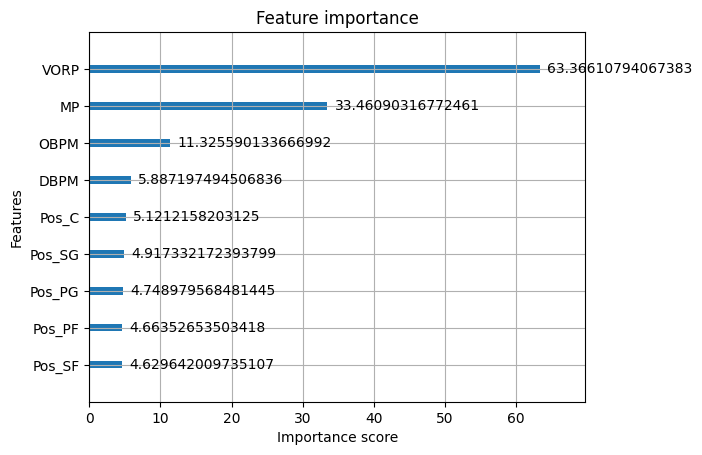

In [647]:
xgb.plot_importance(new_model, importance_type="gain")


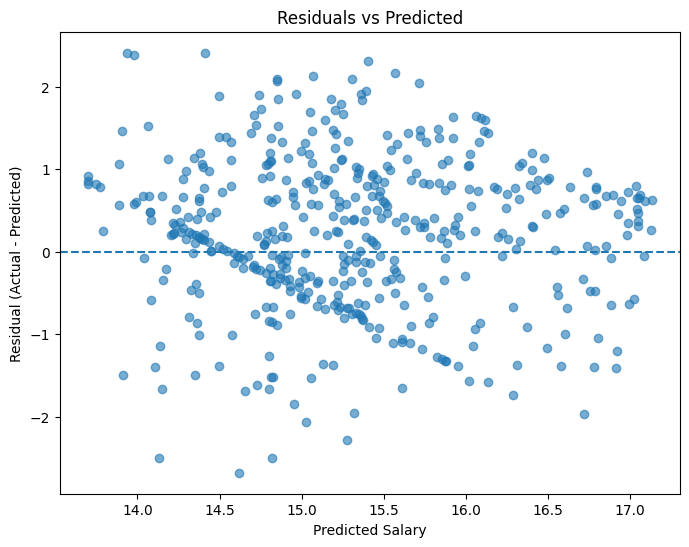

In [648]:
plt.figure(figsize=(8,6))
plt.scatter(df_test["Predicted Log Salary"], df_test["Residual"], alpha=0.6)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted Salary")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals vs Predicted")
plt.show()

<Figure size 1000x600 with 0 Axes>

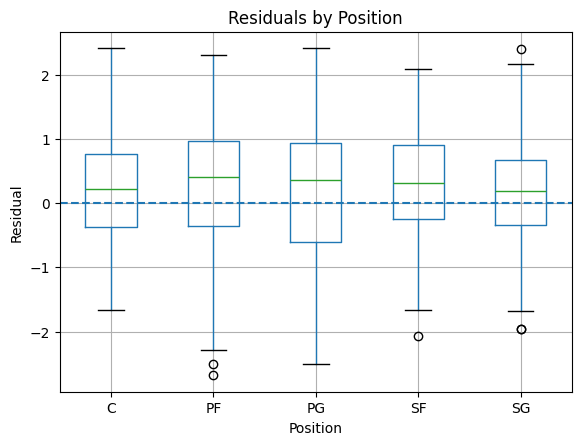

In [649]:
plt.figure(figsize=(10,6))
df_test.boxplot(column="Residual", by="Pos")
plt.axhline(0, linestyle="--")
plt.title("Residuals by Position")
plt.suptitle("")
plt.xlabel("Position")
plt.ylabel("Residual")
plt.show()

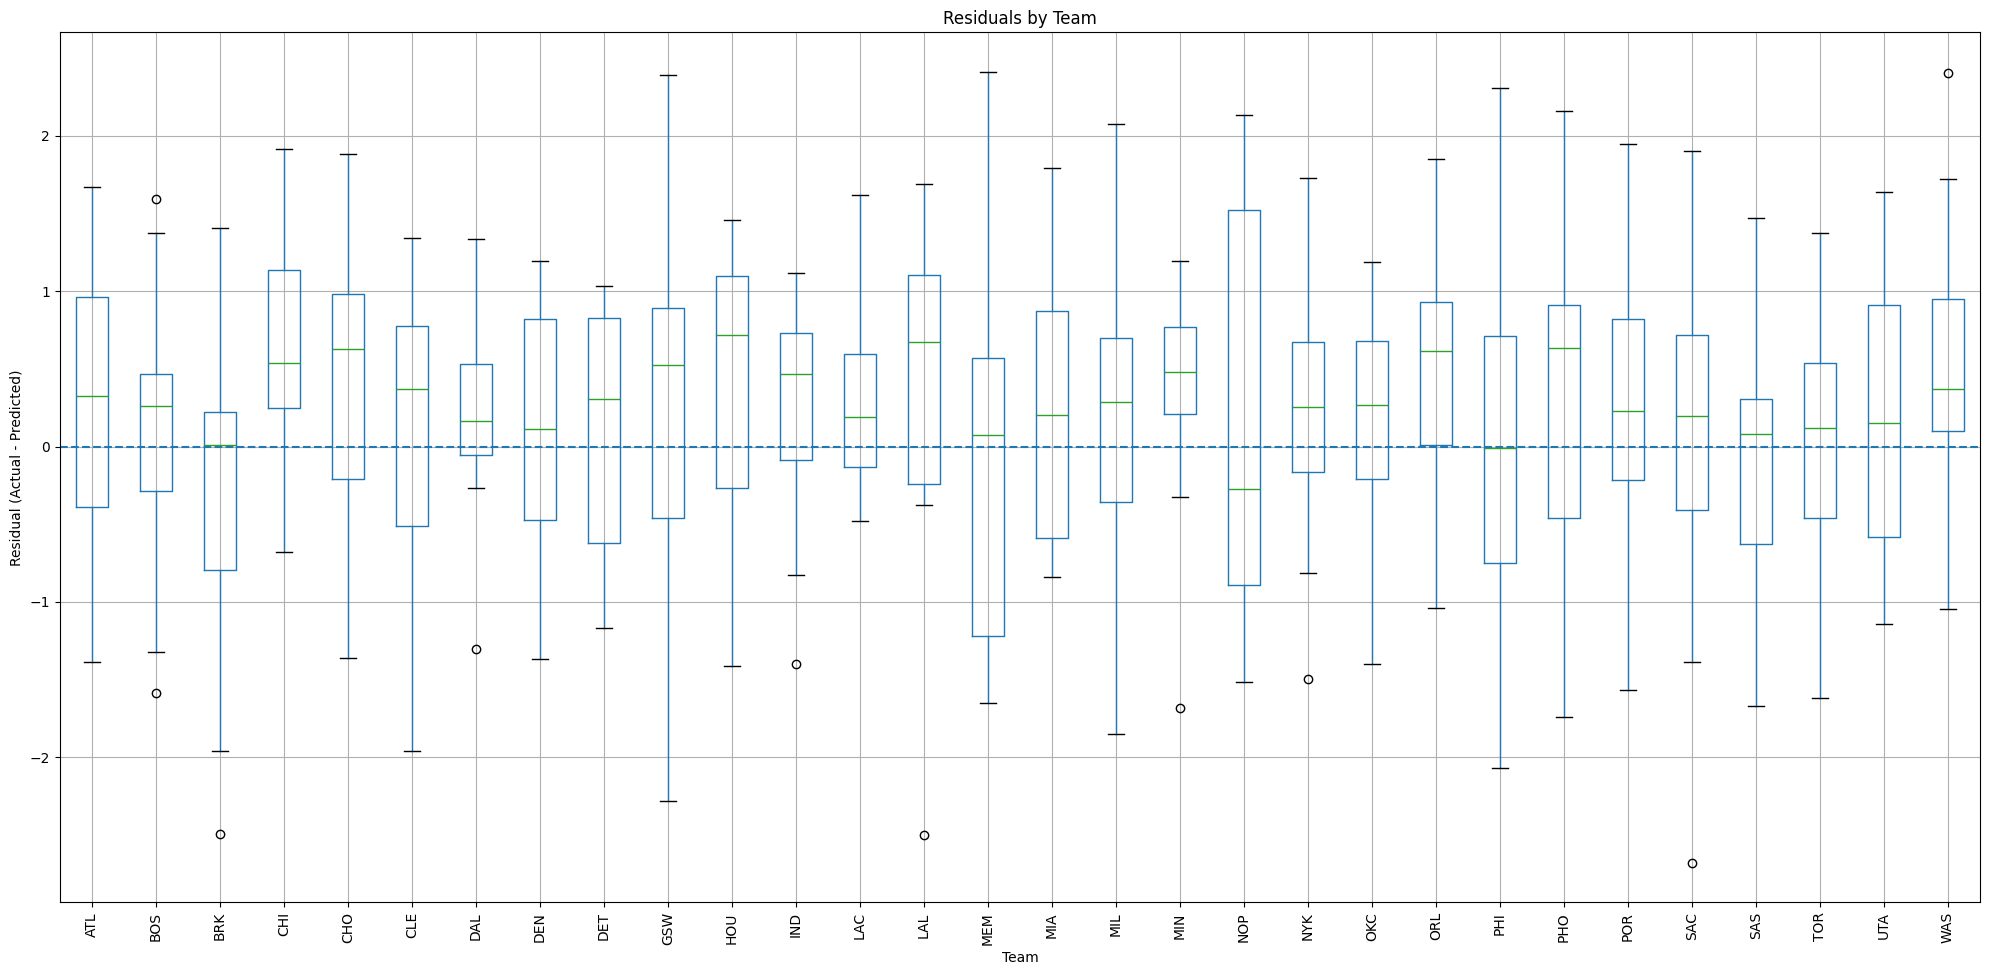

In [650]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
df_test = df_test.sort_values("Residual", ascending=False)
df_test.boxplot(column="Residual", by="Team", ax=ax, rot=90)
ax.axhline(0, linestyle="--")
ax.set_title("Residuals by Team")
ax.set_xlabel("Team")
ax.set_ylabel("Residual (Actual - Predicted)")

plt.suptitle("")  # removes the automatic "Residual by Team" suptitle
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Top 10 Teams by Average Residual')

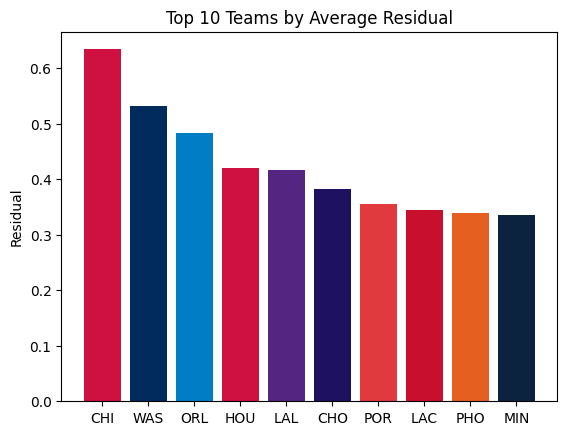

In [664]:
data = df_test.groupby("Team").mean(np.mean).sort_values("Residual",ascending=False).head(10)
data = data.merge(color_df, on="Team", how="left")
plt.bar(x=data["Team"], height=data["Residual"], color=data["hex"])
plt.ylabel("Residual")
plt.title("Top 10 Teams by Average Residual")

Text(0.5, 1.0, 'Bottom 10 Teams by Average Residual')

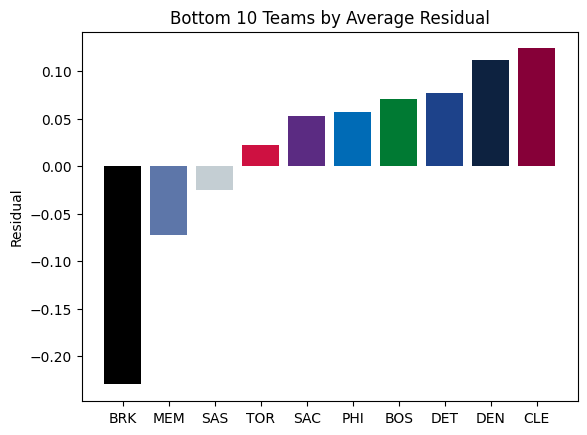

In [665]:
data = df_test.groupby("Team").mean(np.mean).sort_values("Residual",ascending=True).head(10)
data = data.merge(color_df, on="Team", how="left")
plt.bar(x=data["Team"], height=data["Residual"], color=data["hex"])
plt.ylabel("Residual")
plt.title("Bottom 10 Teams by Average Residual")